# Tutorial 6.1 expansion: Offset calculation and theory

In this tutorial expansion we will learn how to define the static equilibrium position of a string from a given external load on the ship. We compare this against theoretical solutions.

We consider a ship in beam waves of width 20m in 200m of water depth. The external constant second order wave drift load is taken in 4m waves. We use a 15cm diameter cable.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit

# Input values
H = 200
L_ship = 400
B_ship = 50
H_signif = 4
g = 9.81
rho_w = 1025

d_anchor = 0.15 # 15cm cable
rho_steel = 7850
E_steel = 210e9

### Part 1: Theoretical line shape

From these basic values we can deduce some other needed values. 
Firstly the second order wave drift foce can be determined, for the whole exposed length of the ship
As a starting pooint, oftne used in maritime apploications, we take the anchor line length as 7 times the water depth.

In [2]:
# Deduced values
F_d = (0.5*rho_w*g*(H_signif/2)**2)*B_ship # Second order wave drift force
print("Drift force = ", F_d/10**3, "kN")

L = 7*H # General sailing rule
print("Anchor line length = ", L, "m")

A_steel = 0.25*np.pi*d_anchor**2
weight = A_steel*(rho_steel-rho_w)*g # General cable, kN/m

Drift force =  1005.525 kN
Anchor line length =  1400 m


We now plot the mooring line shapes on the ship. Remember that for beam waves (coming from the side) we need to look at the ship from the front or the back to see the excursion.

1122.02
605.56


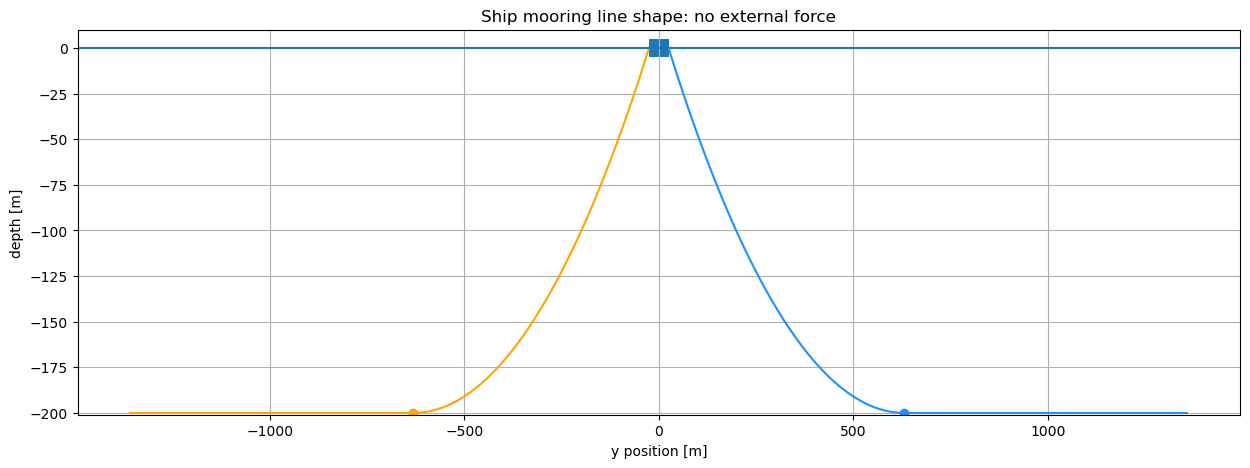

In [3]:
def xtotsolve(Fx, Stot, w, h, xtot):
    Stot = Stot
    S = Fx/w * np.sinh(np.arccosh(h*w/Fx + 1))
    xmax = Fx/w * np.arccosh(h*w/Fx + 1)
    return Stot - S + xmax - xtot

w = weight
h = H
Stot =  L

R_anchor = 0.97*L # Starting point
xtot = R_anchor
Fx = fsolve(xtotsolve, x0=1, args=(Stot, w, h, xtot))[0]
print(round(Fx/1000,2))

def zline(Fx, w, x, h):
    return Fx/w * (np.cosh(w/Fx*x) - 1) - h

xmax = Fx/w * np.arccosh(h*w/Fx + 1)
ymax = R_anchor
print(round(xmax,2))
x = np.linspace(0,xmax)
xpositive = x[::-1]
x1 = np.linspace(B_ship/2, xmax+B_ship/2)
x2 = np.linspace(xmax+B_ship/2,ymax)

z1 = zline(Fx,w,xpositive,h)
z2 = [-h for i in range(len(x2))]

plt.figure(figsize=(15,5))
plt.plot(x1,z1, c="dodgerblue")
plt.plot(x2,z2, c="dodgerblue")
plt.plot(-x1[::-1],z1[::-1], c= "orange")
plt.plot(-x2[::-1],z2[::-1], c= "orange")
plt.plot(xmax+B_ship/2,-h,'o', c="dodgerblue")
plt.plot(-xmax-B_ship/2,-h,'o', c="orange")
plt.xlabel("y position [m]")
plt.ylabel("depth [m]")
plt.title(f"Ship mooring line shape: no external force") #, {Fx/1000:.0f} kN mooring line force")
plt.xlim((-1.1*ymax, 1.1*ymax))
plt.ylim((-h-1,10))
plt.plot([-1.1*ymax, 1.1*ymax],[0,0])
plt.grid()
plt.fill_between([-B_ship/2,-B_ship/2, B_ship/2, B_ship/2, -B_ship/2], [-5, 5, 5, -5, -5]);

8.2 1770.5 764.6 -0.0


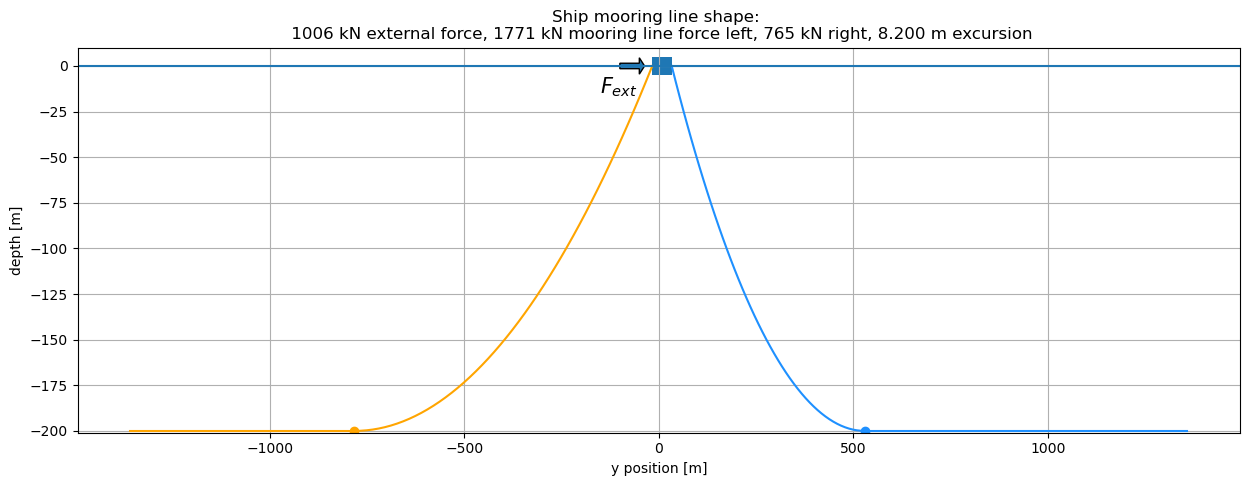

In [4]:
# With external force: left add excursion, untill Fl = Fr+Fext
Fext = F_d

# Initial values
error = 10
xpos = 0
step = 10**(-2)
xtot = R_anchor
while error > 0.01:
    xtotl = xtot + xpos
    xtotr = xtot - xpos
    Fxl = fsolve(xtotsolve, x0=1, args=(Stot, w, h, xtotl))[0]
    Fxr = fsolve(xtotsolve, x0=1, args=(Stot, w, h, xtotr))[0]
    error = Fxr + Fext - Fxl
    xpos += step
print(np.round(xpos-step,2), np.round(Fxl/1000,1),np.round(Fxr/1000,1), np.round(error/1000))

# Right side
xmax = Fxr/w * np.arccosh(h*w/Fxr + 1)
xtemp1 = np.linspace(0,xmax)
xtemp2 = xtemp1[::-1]
x1 = np.linspace(B_ship/2+xpos, xmax+B_ship/2+xpos)
x2 = np.linspace(xmax+B_ship/2+xpos,ymax)
z1 = zline(Fxr,w,xtemp2,h)
z2 = [-h for i in range(len(x2))]
plt.figure(figsize=(15,5))
plt.plot(x1,z1, c="dodgerblue")
plt.plot(x2,z2, c="dodgerblue")
plt.plot(xmax+B_ship/2+xpos,-h,'o', c="dodgerblue")
# Left side
xmax = Fxl/w * np.arccosh(h*w/Fxl + 1)
xtemp1 = np.linspace(0,xmax)
xtemp2 = xtemp1[::-1]
x1 = np.linspace(-B_ship/2+xpos, -xmax-B_ship/2+xpos)
x2 = np.linspace(-xmax-B_ship/2+xpos,-ymax)
z1 = zline(Fxl,w,xtemp2,h)
z2 = [-h for i in range(len(x2))]
plt.plot(x1,z1, c="orange")
plt.plot(x2,z2, c="orange")
plt.plot(-xmax-B_ship/2+xpos,-h,'o', c="orange")
# General
plt.xlabel("y position [m]")
plt.ylabel("depth [m]")
str1 = f"Ship mooring line shape: \n {Fext/1000:.0f} kN external force, {Fxl/1000:.0f} kN "
str2 = f"mooring line force left, {Fxr/1000:.0f} kN right, {xpos-step:.3f} m excursion"
plt.title(str1+str2)
plt.xlim((-1.1*ymax, 1.1*ymax))
plt.ylim((-h-1,10))
plt.plot([-1.1*ymax, 1.1*ymax],[0,0])
plt.grid()
plt.fill_between([-B_ship/2+xpos,-B_ship/2+xpos, B_ship/2+xpos, B_ship/2+xpos, -B_ship/2+xpos], [-5, 5, 5, -5, -5])
plt.arrow(-100, 0, 50, 0, width=3)
plt.annotate("$F_{ext}$",(-150,-15),size=15);
catoff = xpos-step # To be used later in comparison

In [5]:
print(f"Equilibrium force: {Fx/1000:.0f} kN (C and A), offset {0}")
print(f"Offset force: {Fxl/1000:.0f} kN left (C) and {Fxr/1000:.0f} kN right (A), offset {xpos-step:.2f} m")

Equilibrium force: 1122 kN (C and A), offset 0
Offset force: 1771 kN left (C) and 765 kN right (A), offset 8.20 m


### Part 2: Static equilibrium using FEM

In the following cells we begin by making a function that takes the line data, including the line stiffness. In the theoretical caternary line assumption the line is assumed rigid. The function follows the same steps as in the previous tutorial:
1. Discretize the domain (here randomly taken in 31 segments)
2. Compute the initial deformation, with the option to show the "initial plot"
3. Build the system matrices
4. Let the solution converge towards the required line shape
There are some additional keyqord arguments which can be used to show intermediate results.
The function then returns the line shapes (node coordinates), as well as the horizontal force at the end of the line.

In [6]:
from StringForcesAndStiffness import StringForcesAndStiffness

def staticanchor(L, D, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, finalplot=False):
    
    # Step 1: Discretize  ----------------------------------------------------------------------------------------------

    lmax = int(L/31)            # [m] maximum length of each string(wire) element
    nElem = int(np.ceil(L/lmax))# [-] number of elements   
    lElem = L/nElem             # [m] actual tensionless element size
    nNode = nElem + 1           # [-] number of nodes 

    NodeCoord = np.zeros((nNode, 2))
    Element = np.zeros((nElem, 5))

    for iElem in np.arange(0, nElem):
        NodeLeft = iElem
        NodeRight = iElem + 1
        NodeCoord[NodeRight] = NodeCoord[NodeLeft] + [lElem, -H/L*lElem + H ] # +H sets seabed at 0
        Element[iElem, :] = [NodeLeft, NodeRight, m, EA, lElem]
        
    # Step 2: compute initial configuration   --------------------------------------------------------------------

    nDof = 2*nNode                          # number of DOFs
    FreeDof = np.arange(0, nDof)            # free DOFs 
    FixedDof = [0,1, -2, -1]                # fixed DOFs
    FreeDof = np.delete(FreeDof, FixedDof)  # remove the fixed DOFs from the free DOFs array

    # free & fixed array indices
    fx = FreeDof[:, np.newaxis]
    fy = FreeDof[np.newaxis, :]

    SAG = 2000
    s = np.array([i[0] for i in NodeCoord])
    x = D*(s/L)
    y = -H*(s/L)-4*SAG*((x/D)-(x/D)**2)
    u = np.zeros((nDof))
    u[0:nDof+1:2] = x - np.array([i[0] for i in NodeCoord])
    u[1:nDof+1:2] = y - np.array([i[1] for i in NodeCoord])
    # The displacement of the node corresponds to the actual position minus the initial position
    # Remember that we use a Global Coordinate System (GCS) here.
        
    # plot the initial guess   ---------------------------------------------------------------------------------------
    
    if initialplot == True:
        plt.figure()
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H, NodeCoord[NodeRight][1] + u[DofsRight + 1] + H], 
                     '-oy')
            if iElem == 0:
                plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                         [NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H, NodeCoord[NodeRight][1] + u[DofsRight + 1] + H], 
                         '-oy', label="Initial guess")
#             plt.plot([NodeCoord[NodeLeft][0], NodeCoord[NodeRight][0]], 
#                      [NodeCoord[NodeLeft][1], NodeCoord[NodeRight][1]], 'g')
        # plot the supports 
        plt.plot([0, D], [H, 0], 'vr')
        plt.axis('equal');
        
    # Step 3: Assemble system and solve -----------------------------------------------------------------------------

    Pext = np.zeros((nDof))
    for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        m = Element[iElem, 2]
        Pelem = -g*l0*m/2           # Half weight to each node
        Pext[DofsLeft + 1] += Pelem
        Pext[DofsRight + 1] += Pelem
    
    # Convergence parameters   ----------------------------------------------------------------------------------------
    CONV = 0
    PLOT = False
    kIter = 0
    nMaxIter = 200
    TENSION = np.zeros((nElem))

    while CONV == 0:
        kIter += 1
    #     print("Iteration: "+str(kIter)+" ...\n")
        # Check stability - define a number of maximum iterations. If solution
        # hasn't converged, check what is going wrong (if something).
        if kIter > nMaxIter:
            break

        # Assemble vector with internal forces and stiffnes matrix
        K = np.zeros((nDof*nDof)) 
        Fi = np.zeros((nDof))
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            l0 = Element[iElem, 4]
            EA = Element[iElem, 3]
            NodePos = ([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]])
            Fi_elem, K_elem, Tension, WARN = StringForcesAndStiffness(NodePos, EA, l0, TENSION_ONLY)
            TENSION[iElem] = Tension


    #         if WARN:
    #             print("WARNING: Element "+str(iElem+1)+" is under compression.\n")

            Fi[DofsLeft:DofsLeft + 2] += Fi_elem[0]
            Fi[DofsRight:DofsRight + 2] += Fi_elem[1]

            # Assemble the matrices at the correct place
            # Get the degrees of freedom that correspond to each node
            Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
            Dofs_Right = 2*(NodeRight) + np.arange(0, 2)
            nodes = np.append(Dofs_Left , Dofs_Right)
            for i in np.arange(0, 4):
                for j in np.arange(0, 4):
                    ij = nodes[i] + nodes[j]*nDof
                    K[ij] = K[ij] + K_elem[i, j]

        K = K.reshape((nDof, nDof))

        # Calculate residual forces
        R = Pext - Fi

        # Check for convergence
        if np.linalg.norm(R[FreeDof])/np.linalg.norm(Pext[FreeDof]) < 1e-3:
            CONV = 1

        # Calculate increment of displacements
        du = np.zeros((nDof))
        du[FreeDof] = np.linalg.solve(K[fx, fy], R[FreeDof])

        # Apply archlength to help with convergence
        Scale = np.min(np.append(np.array([1]), lElem/np.max(np.abs(du))))
        du = du*Scale   # Enforce that each node does not displace
                        # more (at each iteration) than the length
                        # of the elements

        # Update displacement of nodes
        u += du

        # plot the updated configuration
        if timeplot:
            fig = plt.figure()
            for iElem in np.arange(0, nElem):
                NodeLeft = int(Element[iElem, 0])
                NodeRight = int(Element[iElem, 1])
                DofsLeft = 2*NodeLeft 
                DofsRight = 2*NodeRight
                plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                            [NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H, 
                             NodeCoord[NodeRight][1] + u[DofsRight + 1] + H],
                         '-ok')
                if iElem == 0:
                    plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                                [NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H, 
                                 NodeCoord[NodeRight][1] + u[DofsRight + 1] + H],
                             '-ok', label="Final shape")

            # plot the supports
            plt.plot([0, D], [0, -H], 'vr')
            plt.axis('equal')
            plt.xlabel("x [m]")
            plt.ylabel("y [m]")
            plt.title("Iteration: "+str(kIter))
            plt.pause(0.05)

    if CONV == 1:
        #print("Converged solution at iteration: "+str(kIter))
        for iElem in np.arange(0, nElem):
                NodeLeft = int(Element[iElem, 0])
                NodeRight = int(Element[iElem, 1])
                DofsLeft = 2*NodeLeft 
                DofsRight = 2*NodeRight
                if finalplot == True:
                    plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                                [NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H, NodeCoord[NodeRight][1] + 
                                 u[DofsRight + 1] + H],
                         '-ok')
                    if iElem == 0:
                        plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                                    [NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H, NodeCoord[NodeRight][1] + 
                                     u[DofsRight + 1] + H],
                                 '-ok', label="Final shape")

        if finalplot == True:
            # plot the supports
            plt.plot([0, D], [H, 0], 'vr')
            plt.axis('equal')
            plt.xlabel("x [m]")
            plt.ylabel("y [m]")
            plt.title("Converged solution at iteration: "+str(kIter))
    else:
        print("Solution did not converge")
    
    if initialplot==True or timeplot==True or finalplot==True:
        plt.legend()
    
    # Returns and updates
    xstore = []
    ystore = []
    for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        xstore.append(NodeCoord[NodeLeft][0] + u[DofsLeft]) # All left nodes
        ystore.append(NodeCoord[NodeLeft][1] + u[DofsLeft + 1] + H) # All left nodes
    xstore.append(NodeCoord[NodeRight][0] + u[DofsRight]) # Final right one
    ystore.append(NodeCoord[NodeRight][1] + u[DofsRight + 1] + H) # Final right one
    Fhoriz = TENSION[0]*np.cos(np.arctan(((NodeCoord[1][1]-NodeCoord[0][1])/(NodeCoord[1][0]-NodeCoord[0][0]))))
    
    return xstore, ystore, Fhoriz

The horizontal force contribution is used below as a way of covnerging the line shape towards a specific horizontal force. This is to say that the ship offset is increase in small steps. As the offset increases the horizontal force on the left line increases, and the right one decreases. Once the difference between these two is equal to the drift force the iteration is stopped.

To speed up calculations here the optimization is done in 2 rounds, where first a rough offset solution is found using relatively large offset increments, and then the calculation is partly redone using smaller increments as well.

In [7]:
# Check forces in neutral positionm then increase offset to get correct external force
F_net0 = 0
offset0 = 18 # From tests "we know" it to be at least this value, so it speeds up the calculations
exponent0 = 2

for i in range(2): # Increase number for increased accuracy
    
    print("Round ", i+1)
    F_net, offset, exponent = F_net0, offset0, exponent0
    
    while F_net < F_d:

        L = L                 # [m] string length
        D =  R_anchor
        Dl = R_anchor+offset  # [m] distance between supports
        Dr = R_anchor-offset  # [m] distance between supports
        EA = E_steel*A_steel  # [Pa] stiffness
        m = (weight+rho_w)/g  # [kg] actual-mass

        # Left
        # Check if any node has y < 0 --> "remove" node from line
        y0 = staticanchor(L, D, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, finalplot=False)[1]
        L_new, D_new = L, Dl
        while y0[-2] < 0:
            step = 10**(max(exponent,1)) # don't go too slow
            L_new = L_new-step
            D_new = D_new-step
            L_newl, D_newl = L_new, D_new
            y_new = staticanchor(L_new, D_new, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, 
                                 finalplot=False)[1]
            y0 = y_new
        xl, yl, fl = staticanchor(L_new, D_new, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, 
                              finalplot=False)
        #print("D and F left: ", D_new, fl)

        # Right
        # Check if any node has y < 0 --> "remove" node from line
        y0 = staticanchor(L, D, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, finalplot=False)[1]
        L_new, D_new = L, Dr
        while y0[-2] < 0:
            step = 10**(max(exponent,1)) # don't go too slow
            L_new = L_new-step
            D_new = D_new-step
            L_newr, D_newr = L_new, D_new
            y_new = staticanchor(L_new, D_new, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, 
                                 finalplot=False)[1]
            y0 = y_new
        xr, yr, fr = staticanchor(L_new, D_new, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, 
                              finalplot=False)
        #print("D and F right: ", D_new, fr)

        F_net = fl - fr
        print(f"F_net {F_net:.3f} from offset {offset+0.1*i:.3f}")
        offset += 10**(exponent-2)
    
    F_net0, offset0, exponent0 = 0, offset-2*10**(exponent-2), exponent0-1

Round  1


F_net 909719.014 from offset 18.000


F_net 999638.614 from offset 19.000


F_net 1153375.410 from offset 20.000
Round  2


F_net 1051714.103 from offset 19.100


Lastly the solutions are plotted.

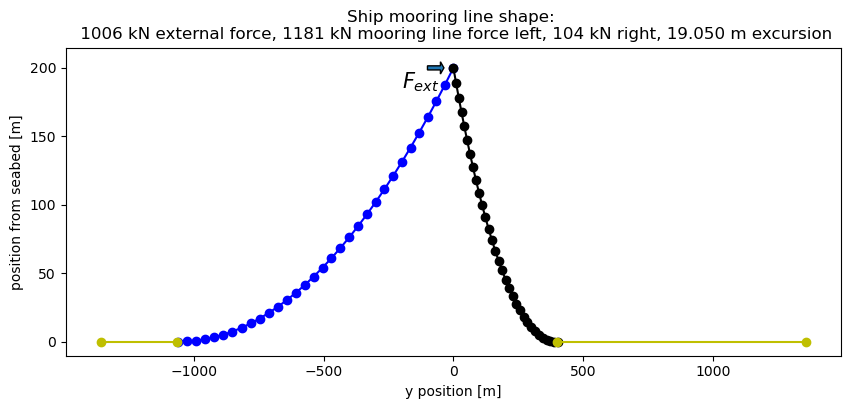

In [8]:
# All (last "safe" one interpolated)
off_final = offset - 10**(exponent-2)/2

# Left
L_finall = L_newl - step/2
D_finall = D_newl - step/2
xl, yl, fl = staticanchor(L_finall, D_finall, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, finalplot=False)

# Right
L_finalr = L_newr + step/2
D_finalr = D_newr + step/2
xr, yr, fr = staticanchor(L_finalr, D_finalr, EA, m, g, TENSION_ONLY=1, initialplot=False, timeplot=False, finalplot=False)

plt.figure(figsize=(10,4))
plt.plot([-i for i in xl], yl, '-ob')
plt.plot([-D, -D_newl],[0,0],'-oy')
plt.plot(xr, yr, '-ok')
plt.plot([D_newr, D],[0,0],'-oy')

plt.xlabel("y position [m]")
plt.ylabel("position from seabed [m]")
str1 = f"Ship mooring line shape: \n {Fext/1000:.0f} kN external force, {fl/1000:.0f} kN "
str2 = f"mooring line force left, {fr/1000:.0f} kN right, {off_final:.3f} m excursion"
plt.title(str1+str2)
#plt.fill_between([-B/2+offset,-B/2+offset, B/2+offset, B/2+offset, -B/2+offset], [-5+H, 5+H, 5+H, -5+H, -5+H])
plt.arrow(-100, H, 50, 0, width=3)
plt.annotate("$F_{ext}$",(-200,-15+H),size=15);

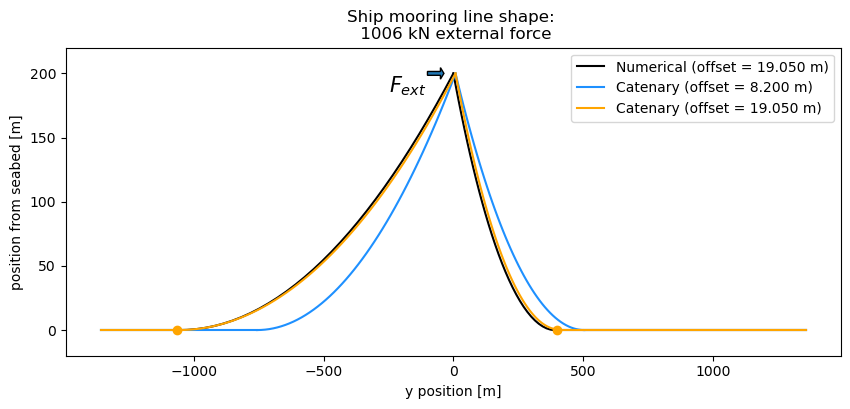

In [9]:
plt.figure(figsize=(10,4))

# Numerical solution
plt.plot([-i for i in xl], yl, '-k')
plt.plot([-D, -D_newl],[0,0],'-')
plt.plot(xr, yr, '-k')
plt.plot([D_newr, D],[0,0],'-k', label=f"Numerical (offset = {off_final:.3f} m)")

# Catenary line original offset
B = 0 # Makes ship-gap dissapear
# Right side
xmax = Fxr/w * np.arccosh(h*w/Fxr + 1)
xtemp1 = np.linspace(0,xmax)
xtemp2 = xtemp1[::-1]
x1 = np.linspace(B/2+xpos, xmax+B/2+xpos)
x2 = np.linspace(xmax+B/2+xpos,ymax)
z1 = zline(Fxr,w,xtemp2,h)
z1 = [i+H for i in z1]
z2 = [-h for i in range(len(x2))]
z2 = [i+H for i in z2]
plt.plot(x1,z1, c="dodgerblue")
plt.plot(x2,z2, c="dodgerblue")
plt.plot(xmax+B/2+xpos,-h, c="dodgerblue")
# Left side
xmax = Fxl/w * np.arccosh(h*w/Fxl + 1)
xtemp1 = np.linspace(0,xmax)
xtemp2 = xtemp1[::-1]
x1 = np.linspace(-B/2+xpos, -xmax-B/2+xpos)
x2 = np.linspace(-xmax-B/2+xpos,-ymax)
z1 = zline(Fxl,w,xtemp2,h)
z1 = [i+H for i in z1]
z2 = [-h for i in range(len(x2))]
z2 = [i+H for i in z2]
plt.plot(x1,z1, c="dodgerblue")
plt.plot(x2,z2, c="dodgerblue", label=f"Catenary (offset = {catoff:.3f} m)")

# Catenary line numerical offset
# Right side
plt.plot(D_newr,0,marker="o",color="orange")
xmax = D_newr
xtemp1 = np.linspace(0,xmax)
xtemp2 = xtemp1[::-1]
x1 = np.linspace(B/2+catoff, xmax+B/2+catoff)
x2 = np.linspace(xmax+B/2+catoff,ymax)
aaa = D_newr
z1 = aaa*np.cosh((-x1+catoff)/aaa)-1.5*aaa
z1 = [i+H for i in z1[::-1]]
z1 = [i*(200/max(z1)) for i in z1] # Small visual correction
z2 = [-h for i in range(len(x2))]
z2 = [i+H for i in z2]
plt.plot(x1,z1, c="orange")
plt.plot(x2,z2, c="orange")
# Left side
plt.plot(-D_newl,0,marker="o",color="orange")
xmax = D_newl
xtemp1 = np.linspace(0,xmax)
xtemp2 = xtemp1[::-1]
x1 = np.linspace(-B/2+xpos, -xmax-B/2+xpos)
x2 = np.linspace(-xmax-B/2+xpos,-ymax)
z1 = zline(Fxl,w,xtemp2,h)
z1 = [i+H for i in z1]
z1 = [i*(200/max(z1)) for i in z1] # Small visual correction
z2 = [-h for i in range(len(x2))]
z2 = [i+H for i in z2]
plt.plot(x1,z1, c="orange")
plt.plot(x2,z2, c="orange", label=f"Catenary (offset = {off_final:.3f} m)")


plt.xlabel("y position [m]")
plt.ylabel("position from seabed [m]")
str1 = f"Ship mooring line shape: \n {Fext/1000:.0f} kN external force"
plt.title(str1)
plt.arrow(-100, H, 50, 0, width=3)
plt.annotate("$F_{ext}$",(-250,-15+H),size=15)
plt.ylim((-20,220))
plt.legend();

We can see that for larger offsets the results do differ quite a lot. This is mainly due to the diferent stiffness and mass influence assumptions in the two models. When comparing the line shape however we see a good accordance when equal offsets are imposed.